In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import greycomatrix, greycoprops
from matplotlib import pyplot as plt
%matplotlib inline
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold 
from sklearn.ensemble import RandomForestClassifier
import scikitplot as skplt
import matplotlib.pyplot as plt
import predictor
import pickle
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import shutil
# shutil.copy('/content/drive/MyDrive/DA_Library/EDA.py','EDA.py')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# import EDA as eda
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold 
import seaborn as sns

In [2]:
def create_empty_df():
    df = pd.DataFrame()
    df['area'] = None
    df['perimeter'] = None
    df['red_mean'] = None
    df['green_mean'] = None
    df['blue_mean'] = None
    df['f1'] = None
    df['f2'] = None
    df['red_std'] = None
    df['green_std'] = None
    df['blue_std'] = None
    df['f4'] = None
    df['f5'] = None
    df['f6'] = None
    df['f7'] = None
    df['f8'] = None
    df['label'] = None
    return df

# Generating Pre-processed Images 

In [3]:
import cv2
import numpy as np
filename = './Plant_leave_diseases_dataset_with_augmentation/Apple___healthy/image(1).jpg'

filename = 'a2.jpg'
main_img = cv2.imread(filename)
img = cv2.cvtColor(main_img, cv2.COLOR_BGR2RGB)


gs = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
cv2.imwrite('greayscale.png',gs)

blur = cv2.GaussianBlur(gs, (25,25),0)
cv2.imwrite('blur.png',blur)

ret_otsu,im_bw_otsu = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
cv2.imwrite('otsus.png',im_bw_otsu)

kernel = np.ones((25,25),np.uint8)
closing = cv2.morphologyEx(im_bw_otsu, cv2.MORPH_CLOSE, kernel)
cv2.imwrite('closing.png',closing)


#Shape features
contours, _ = cv2.findContours(closing,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
# cv2.imwrite('contours.png',contours)
cnt = contours[0]

current_frame = main_img
filtered_image = closing/255

#Elementwise Multiplication of range bounded filtered_image with current_frame
current_frame[0:current_frame.shape[0], 0:current_frame.shape[1], 0] = np.multiply(current_frame[0:current_frame.shape[0], 0:current_frame.shape[1], 0], filtered_image) #B channel
current_frame[0:current_frame.shape[0], 0:current_frame.shape[1], 1] = np.multiply(current_frame[0:current_frame.shape[0], 0:current_frame.shape[1], 1], filtered_image) #G channel
current_frame[0:current_frame.shape[0], 0:current_frame.shape[1], 2] = np.multiply(current_frame[0:current_frame.shape[0], 0:current_frame.shape[1], 2], filtered_image) #R channel

cv2.imwrite('final_output.png',current_frame)

True

In [4]:
def feature_extractor(filename):
    '''
    input params: 
    filename : path of the file that we want to process

    Output params:
    l : Feature vector
    '''

    try:
        main_img = cv2.imread(filename)
        img = cv2.cvtColor(main_img, cv2.COLOR_BGR2RGB)
    except:
        return "Invalid"

    #Preprocessing
    

    gs = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gs, (25,25),0)
    ret_otsu,im_bw_otsu = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    kernel = np.ones((25,25),np.uint8)
    closing = cv2.morphologyEx(im_bw_otsu, cv2.MORPH_CLOSE, kernel)

    #Shape features
    contours, _ = cv2.findContours(closing,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    M = cv2.moments(cnt)
    area = cv2.contourArea(cnt)
    if area==0:
        return "Invalid"
    perimeter = cv2.arcLength(cnt,True)

    current_frame = main_img
    filtered_image = closing/255

    #Elementwise Multiplication of range bounded filtered_image with current_frame
    current_frame[0:current_frame.shape[0], 0:current_frame.shape[1], 0] = np.multiply(current_frame[0:current_frame.shape[0], 0:current_frame.shape[1], 0], filtered_image) #B channel
    current_frame[0:current_frame.shape[0], 0:current_frame.shape[1], 1] = np.multiply(current_frame[0:current_frame.shape[0], 0:current_frame.shape[1], 1], filtered_image) #G channel
    current_frame[0:current_frame.shape[0], 0:current_frame.shape[1], 2] = np.multiply(current_frame[0:current_frame.shape[0], 0:current_frame.shape[1], 2], filtered_image) #R channel

    img = current_frame


    #Color features
    red_channel = img[:,:,0]
    green_channel = img[:,:,1] #show the intensities of green channe
    blue_channel = img[:,:,2]

    red_mean = np.mean(red_channel)
    green_mean = np.mean(green_channel)
    blue_mean = np.mean(blue_channel)
    #standard deviation for colour feature from the image.    
    red_std = np.std(red_channel)
    green_std = np.std(green_channel)
    blue_std = np.std(blue_channel)
    
    #amt.of green color in the image
    gr = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    boundaries = [([30,0,0],[70,255,255])]
    for (lower, upper) in boundaries:
        mask = cv2.inRange(gr, (36, 0, 0), (70, 255,255))
        ratio_green = cv2.countNonZero(mask)/(img.size/3)
        f1=np.round(ratio_green, 2)
    #amt. of non green part of the image   
    f2=1-f1

    #Texture features using grey level cooccurance matrix
    img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    g=greycomatrix(img, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4])

    #with the help of glcm find the contrast
    contrast = greycoprops(g, 'contrast')
    f4=contrast[0][0]+contrast[0][1]+contrast[0][2]+contrast[0][3]
    #[0][3] represent no. of times grey level 3 appears at the right of 0


    #with the help of glcm find the dissimilarity 
    dissimilarity = greycoprops(g, prop='dissimilarity')
    f5=dissimilarity[0][0]+dissimilarity[0][1]+dissimilarity[0][2]+dissimilarity[0][3]

    #with the help of glcm find the homogeneity
    homogeneity = greycoprops(g, prop='homogeneity')
    f6=homogeneity[0][0]+homogeneity[0][1]+homogeneity[0][2]+homogeneity[0][3]

    energy = greycoprops(g, prop='energy')
    f7=energy[0][0]+energy[0][1]+energy[0][2]+energy[0][3]


    correlation = greycoprops(g,prop= 'correlation')
    f8=correlation[0][0]+correlation[0][1]+correlation[0][2]+correlation[0][3]



    l = [area, perimeter, red_mean, green_mean, blue_mean,
         f1, f2, red_std, green_std, blue_std,
        f4,f5,f6,f7,f8]
    return l

In [5]:
def process_folder(folderpath,df_f,label_f):
    '''
    input params:
    folderpath : Path of the folder that we want to process
    df_f = dataframe for specific disease
    label_f : label corresponding to the specific disease

    Output params:
    df_f = Dataframe consisting processed vectors
    '''
    imagelist = os.listdir(folderpath)  # stores all the imagepaths in the python list
    for image in imagelist:
        imagepath = os.path.join(folderpath, image)
        im_feature = feature_extractor(imagepath) 
        if im_feature == "Invalid":
            continue
        im_feature.append(label_f)  # appending label to feature vector
        df_f.loc[len(df_f)] = im_feature 
        if len(df_f)%500 ==0:
            print(len(df_f))

    return df_f

In [6]:
def process_plant(folderpaths, labels, savepath):
    '''
    input params:
    folderpaths : List of the folderpaths for specific Plant
    labels : List of labels 
    savepath : Path to export datasheet

    Output params:
    None
    '''
    datasheet = create_empty_df()
    for i in range(len(folderpaths)):
        datasheet = process_folder(folderpaths[i],datasheet,labels[i])

    datasheet.to_excel(savepath)

    return None

# Apple

In [ ]:
import warnings
warnings.filterwarnings('ignore')

global_folder = './Plant_leave_diseases_dataset_with_augmentation/'

folderpaths = [global_folder+ 'Apple___healthy',
              global_folder+ 'Apple___Apple_scab',
              global_folder+ 'Apple___Black_rot',
              global_folder+ 'Apple___Cedar_apple_rust'
]

labels = [0,1,2,3]
savepath = './pre_processed/dataset_apple.xlsx'
process_plant(folderpaths, labels, savepath)

# Grape

In [ ]:
import warnings
warnings.filterwarnings('ignore')

global_folder = './Plant_leave_diseases_dataset_with_augmentation/'

folderpaths = [global_folder+ 'Grape___healthy',
              global_folder+ 'Grape___Black_rot',
              global_folder+ 'Grape___Esca_(Black_Measles)',
              global_folder+ 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)'
              ]

labels = [0,1,2,3]
savepath = './pre_processed/dataset_grape.xlsx'
process_plant(folderpaths, labels, savepath)

# Corn 

In [ ]:
import warnings
warnings.filterwarnings('ignore')

global_folder = './Plant_leave_diseases_dataset_with_augmentation/'

folderpaths = [global_folder+ 'Corn___healthy',
              global_folder+ 'Corn___Cercospora_leaf_spot Gray_leaf_spot',
              global_folder+ 'Corn___Common_rust',
              global_folder+ 'Corn___Northern_Leaf_Blight'
              ]

labels = [0,1,2,3]
savepath = './pre_processed/dataset_corn.xlsx'
process_plant(folderpaths, labels, savepath)

# Tomato

In [ ]:
import warnings
warnings.filterwarnings('ignore')

global_folder = './Plant_leave_diseases_dataset_with_augmentation/'

folderpaths = [global_folder+ 'Tomato___healthy',
              global_folder+ 'Tomato___Bacterial_spot',
              global_folder+ 'Tomato___Early_blight',
              global_folder+ 'Tomato___Late_blight',
              global_folder+ 'Tomato___Leaf_Mold',
              global_folder+ 'Tomato___Septoria_leaf_spot',
              global_folder+'Tomato___Spider_mites Two-spotted_spider_mite',
              global_folder+ 'Tomato___Target_Spot',
              global_folder+'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
              global_folder+ 'Tomato___Tomato_mosaic_virus'
              ]

labels = [0,1,2,3,4,5,6,7,8,9,10]
savepath = './pre_processed/dataset_tomato.xlsx'
process_plant(folderpaths, labels, savepath)

# Potato

In [ ]:
import warnings
warnings.filterwarnings('ignore')

global_folder = './Plant_leave_diseases_dataset_with_augmentation/'

folderpaths = [global_folder+ 'Potato___healthy',
              global_folder+ 'Potato___Early_blight',
              global_folder+ 'Potato___Late_blight'
              ]

labels = [0,1,2]
savepath = './pre_processed/dataset_potato.xlsx'
process_plant(folderpaths, labels, savepath)

# Apple Training

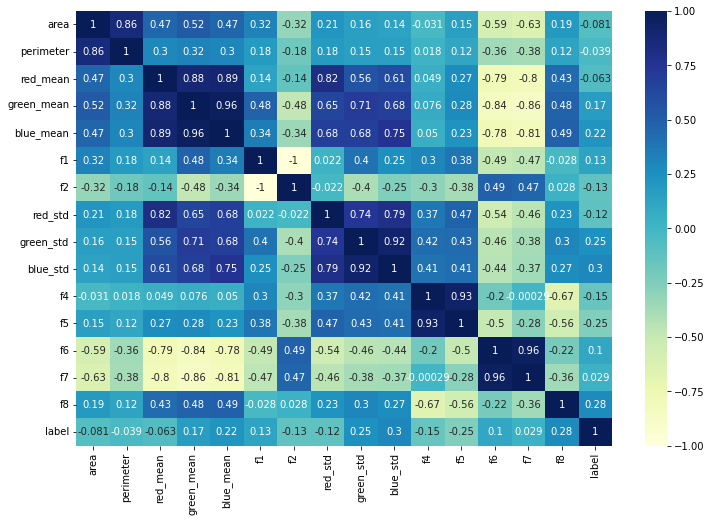

In [7]:
fig = plt.gcf()
fig.set_size_inches(12, 8)
file_name="./pre_processed/dataset_apple.xlsx"
dfs = pd.read_excel(file_name)
dfs.drop(['Unnamed: 0'],axis = 1, inplace=True)
dataplot = sns.heatmap(dfs.corr(), cmap="YlGnBu", annot=True)
cleaned_data = dfs.drop(['green_mean', 'red_std', 'blue_std', 'f5', 'f8','f1'],axis = 1, inplace=False)
cleaned_data = cleaned_data.dropna(how='any',axis=0)

In [8]:
df = dfs.reset_index()
X = df.drop(['index','label'],axis = 1, inplace=False)
y = df['label']
print(X.shape)
print(y.shape)
k = 5
kf = KFold(n_splits=k, random_state=9, shuffle = True)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state = 50,n_estimators = 50,max_samples = 0.7)
 
acc_score = []

for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
    model = RandomForestClassifier(random_state = 50,n_estimators = 50,max_samples = 0.7)
    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)            # classification
    acc = accuracy_score(pred_values , y_test)     # Classification

    #acc = model.score(X_test,y_test)                # Regression
    
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k
 
print('Score of each fold - {}'.format(acc_score))
print('Avg Score : {}'.format(avg_acc_score))

(4633, 15)
(4633,)
Score of each fold - [0.8522114347357066, 0.8748651564185544, 0.8932038834951457, 0.8876889848812095, 0.8725701943844493]
Avg Score : 0.8761079307830132


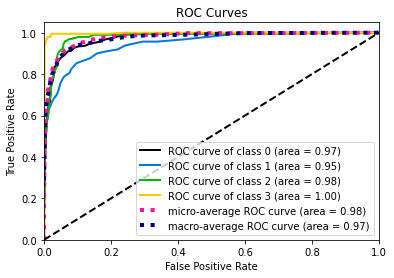

              precision    recall  f1-score   support

           0       0.89      0.90      0.90       321
           1       0.87      0.66      0.75       210
           2       0.80      0.93      0.86       198
           3       0.92      0.98      0.95       197

    accuracy                           0.87       926
   macro avg       0.87      0.87      0.87       926
weighted avg       0.87      0.87      0.87       926

Training Score:  0.996762357004101


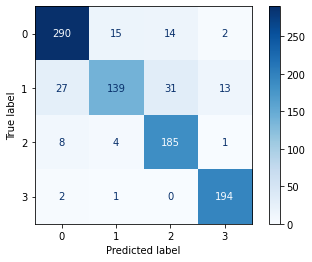

In [9]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve
y_true = y_test
y_probas = model.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()
y_pred = model.predict(X_test)
plot_confusion_matrix(model, X_test, y_test, values_format = 'd',cmap = 'Blues',display_labels = ['0','1','2','3'])
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))
from sklearn.ensemble import RandomForestClassifier
lm = RandomForestClassifier(random_state = 50,n_estimators = 50,max_samples = 0.7)
lm.fit(X,y)
print('Training Score: ',lm.score(X,y))
lm.feature_importances_
import pickle
filename = './model/Applemodel_V1.sav'
pickle.dump(lm, open(filename, 'wb'))


# Grape Training

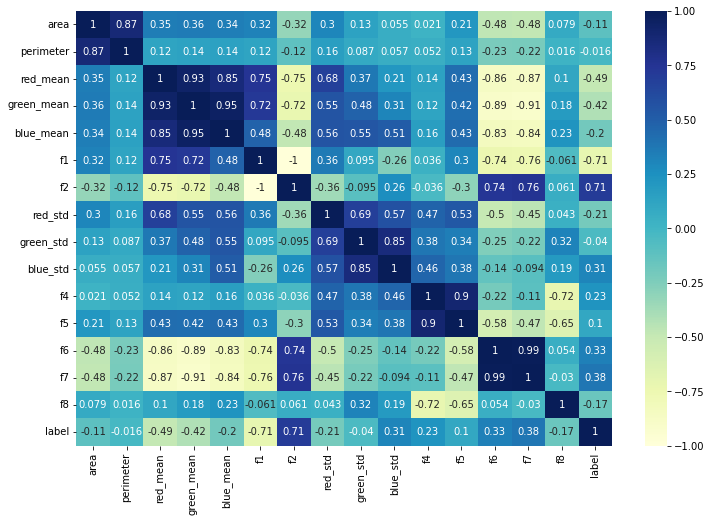

In [10]:
fig = plt.gcf()
fig.set_size_inches(12, 8)
file_name="./pre_processed/dataset_grape.xlsx"
dfs = pd.read_excel(file_name)
dfs.drop(['Unnamed: 0'],axis = 1, inplace=True)
dataplot = sns.heatmap(dfs.corr(), cmap="YlGnBu", annot=True)
cleaned_data = cleaned_data.dropna(how='any',axis=0)

(4625, 15)
(4625,)
Score of each fold - [0.8756756756756757, 0.8594594594594595, 0.8735135135135135, 0.8616216216216216, 0.8724324324324324]
Avg Score : 0.8685405405405404


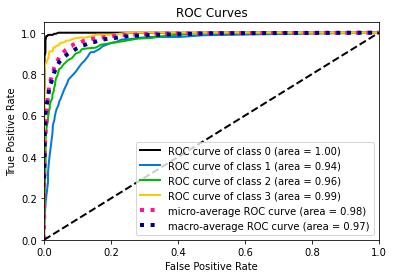

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       191
           1       0.76      0.85      0.80       245
           2       0.90      0.78      0.84       278
           3       0.91      0.92      0.92       211

    accuracy                           0.87       925
   macro avg       0.88      0.88      0.88       925
weighted avg       0.88      0.87      0.87       925

Training Score:  0.993945945945946


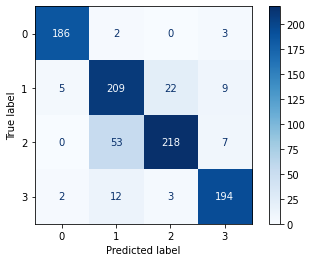

In [11]:
df = dfs.reset_index()
X = df.drop(['index','label'],axis = 1, inplace=False)
y = df['label']
print(X.shape)
print(y.shape)
k = 5
kf = KFold(n_splits=k, random_state=9, shuffle = True)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state = 50,n_estimators = 50,max_samples = 0.7)
 
acc_score = []

for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
    model = RandomForestClassifier(random_state = 50,n_estimators = 50,max_samples = 0.7)
    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)            # classification
    acc = accuracy_score(pred_values , y_test)     # Classification

    #acc = model.score(X_test,y_test)                # Regression
    
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k
 
print('Score of each fold - {}'.format(acc_score))
print('Avg Score : {}'.format(avg_acc_score))
y_true = y_test
y_probas = model.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()
y_pred = model.predict(X_test)
plot_confusion_matrix(model, X_test, y_test, values_format = 'd',cmap = 'Blues',display_labels = ['0','1','2','3'])
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))
from sklearn.ensemble import RandomForestClassifier
lm = RandomForestClassifier(random_state = 50,n_estimators = 50,max_samples = 0.7)
lm.fit(X,y)
print('Training Score: ',lm.score(X,y))
lm.feature_importances_
import pickle
filename = './model/Grapemodel_V1.sav'
pickle.dump(lm, open(filename, 'wb'))


# Corn Training

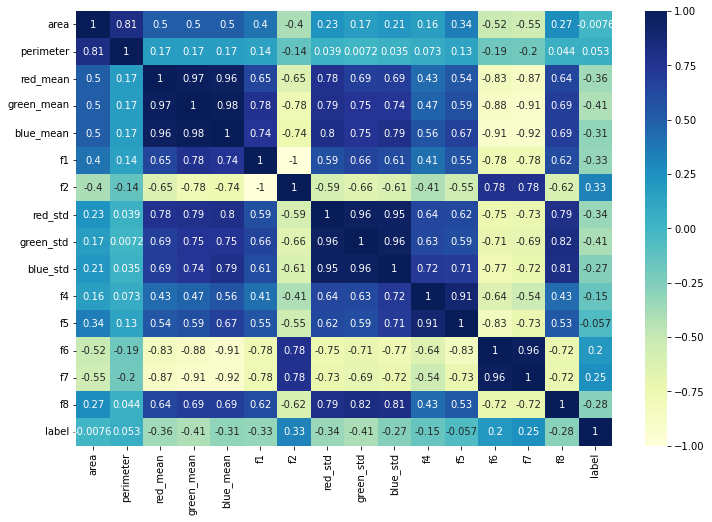

In [12]:
fig = plt.gcf()
fig.set_size_inches(12, 8)
file_name="./pre_processed/dataset_corn.xlsx"
dfs = pd.read_excel(file_name)
dfs.drop(['Unnamed: 0'],axis = 1, inplace=True)
dataplot = sns.heatmap(dfs.corr(), cmap="YlGnBu", annot=True)
cleaned_data = cleaned_data.dropna(how='any',axis=0)

(4330, 15)
(4330,)
Score of each fold - [0.8475750577367206, 0.8799076212471132, 0.8579676674364896, 0.8521939953810623, 0.8371824480369515]
Avg Score : 0.8549653579676674


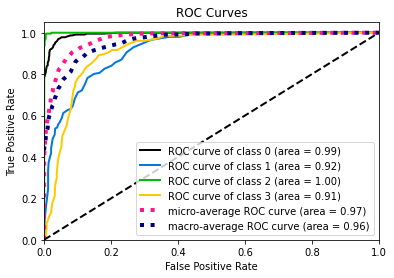

              precision    recall  f1-score   support

           0       0.90      0.95      0.93       228
           1       0.73      0.63      0.68       201
           2       0.98      1.00      0.99       233
           3       0.69      0.74      0.72       204

    accuracy                           0.84       866
   macro avg       0.83      0.83      0.83       866
weighted avg       0.83      0.84      0.83       866

Training Score:  0.997228637413395


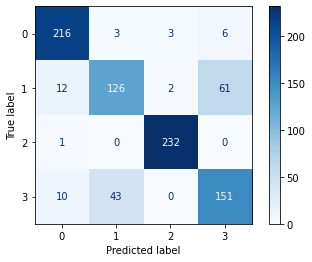

In [13]:
df = dfs.reset_index()
X = df.drop(['index','label'],axis = 1, inplace=False)
y = df['label']
print(X.shape)
print(y.shape)
k = 5
kf = KFold(n_splits=k, random_state=9, shuffle = True)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state = 50,n_estimators = 50,max_samples = 0.7)
 
acc_score = []

for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
    model = RandomForestClassifier(random_state = 50,n_estimators = 50,max_samples = 0.7)
    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)            # classification
    acc = accuracy_score(pred_values , y_test)     # Classification

    #acc = model.score(X_test,y_test)                # Regression
    
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k
 
print('Score of each fold - {}'.format(acc_score))
print('Avg Score : {}'.format(avg_acc_score))
y_true = y_test
y_probas = model.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()
y_pred = model.predict(X_test)
plot_confusion_matrix(model, X_test, y_test, values_format = 'd',cmap = 'Blues',display_labels = ['0','1','2','3'])
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))
from sklearn.ensemble import RandomForestClassifier
lm = RandomForestClassifier(random_state = 50,n_estimators = 50,max_samples = 0.7)
lm.fit(X,y)
print('Training Score: ',lm.score(X,y))
lm.feature_importances_
import pickle
filename = './model/Cornmodel_V1.sav'
pickle.dump(lm, open(filename, 'wb'))


# Tomato Training 

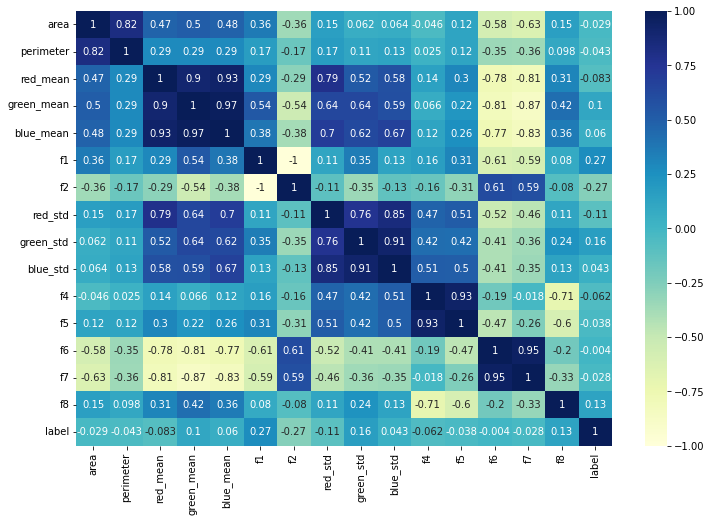

In [14]:
file_name="./pre_processed/dataset_tomato.xlsx"
dfs = pd.read_excel(file_name)
dfs.drop(['Unnamed: 0'],axis = 1, inplace=True)
fig = plt.gcf()
fig.set_size_inches(12, 8)
dataplot = sns.heatmap(dfs.corr(), cmap="YlGnBu", annot=True)
cleaned_data = cleaned_data.dropna(how='any',axis=0)

(18720, 15)
(18720,)
Score of each fold - [0.719551282051282, 0.7160790598290598, 0.7227564102564102, 0.7072649572649573, 0.7120726495726496]
Avg Score : 0.7155448717948718


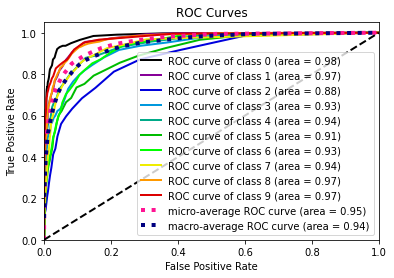

              precision    recall  f1-score   support

           0       0.80      0.84      0.82       317
           1       0.71      0.79      0.75       404
           2       0.59      0.26      0.36       218
           3       0.63      0.60      0.61       361
           4       0.69      0.53      0.60       206
           5       0.66      0.51      0.57       352
           6       0.53      0.63      0.57       311
           7       0.62      0.66      0.64       281
           8       0.80      0.91      0.85      1085
           9       0.78      0.73      0.76       209

    accuracy                           0.71      3744
   macro avg       0.68      0.65      0.65      3744
weighted avg       0.71      0.71      0.70      3744

Training Score:  0.9952991452991453


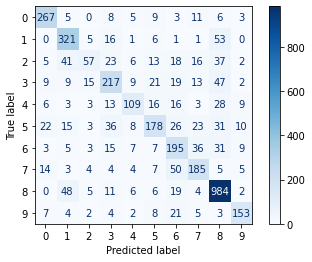

In [15]:
df = dfs.reset_index()
X = df.drop(['index','label'],axis = 1, inplace=False)
y = df['label']
print(X.shape)
print(y.shape)
k = 5
kf = KFold(n_splits=k, random_state=9, shuffle = True)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state = 50,n_estimators = 50,max_samples = 0.7)
 
acc_score = []

for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
    model = RandomForestClassifier(random_state = 50,n_estimators = 50,max_samples = 0.7)
    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)            # classification
    acc = accuracy_score(pred_values , y_test)     # Classification

    #acc = model.score(X_test,y_test)                # Regression
    
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k
 
print('Score of each fold - {}'.format(acc_score))
print('Avg Score : {}'.format(avg_acc_score))
y_true = y_test
y_probas = model.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()
y_pred = model.predict(X_test)
plot_confusion_matrix(model, X_test, y_test, values_format = 'd',cmap = 'Blues',display_labels = ['0','1','2','3','4','5','6','7','8','9'])
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))
from sklearn.ensemble import RandomForestClassifier
lm = RandomForestClassifier(random_state = 50,n_estimators = 50,max_samples = 0.7)
lm.fit(X,y)
print('Training Score: ',lm.score(X,y))
lm.feature_importances_
import pickle
filename = './model/Tomatomodel_V1.sav'
pickle.dump(lm, open(filename, 'wb'))

# Potato Training

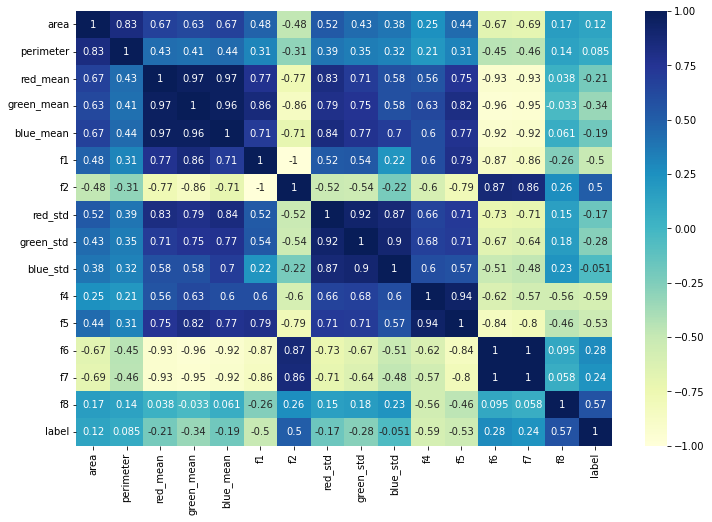

In [16]:
fig = plt.gcf()
fig.set_size_inches(12, 8)
file_name="./pre_processed/dataset_potato.xlsx"
dfs = pd.read_excel(file_name)
dfs.drop(['Unnamed: 0'],axis = 1, inplace=True)
dataplot = sns.heatmap(dfs.corr(), cmap="YlGnBu", annot=True)
cleaned_data = cleaned_data.dropna(how='any',axis=0)

(2970, 15)
(2970,)
Score of each fold - [0.9225589225589226, 0.9343434343434344, 0.9107744107744108, 0.9242424242424242, 0.9023569023569024]
Avg Score : 0.9188552188552188


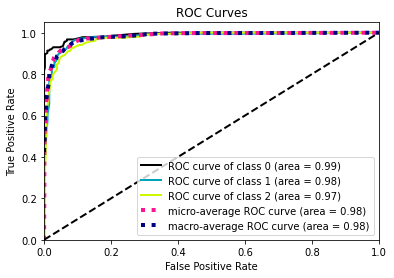

              precision    recall  f1-score   support

           0       0.94      0.91      0.93       185
           1       0.92      0.88      0.90       206
           2       0.85      0.91      0.88       203

    accuracy                           0.90       594
   macro avg       0.91      0.90      0.90       594
weighted avg       0.90      0.90      0.90       594

Training Score:  0.9956228956228956


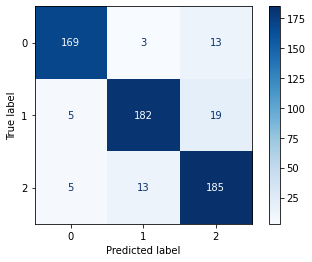

In [17]:
df = dfs.reset_index()
X = df.drop(['index','label'],axis = 1, inplace=False)
y = df['label']
print(X.shape)
print(y.shape)
k = 5
kf = KFold(n_splits=k, random_state=9, shuffle = True)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state = 50,n_estimators = 50,max_samples = 0.7)
 
acc_score = []

for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
    model = RandomForestClassifier(random_state = 50,n_estimators = 50,max_samples = 0.7)
    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)            # classification
    acc = accuracy_score(pred_values , y_test)     # Classification

    #acc = model.score(X_test,y_test)                # Regression
    
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k
 
print('Score of each fold - {}'.format(acc_score))
print('Avg Score : {}'.format(avg_acc_score))
y_true = y_test
y_probas = model.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()
y_pred = model.predict(X_test)
plot_confusion_matrix(model, X_test, y_test, values_format = 'd',cmap = 'Blues',display_labels = ['0','1','2'])
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))
from sklearn.ensemble import RandomForestClassifier
lm = RandomForestClassifier(random_state = 50,n_estimators = 50,max_samples = 0.7)
lm.fit(X,y)
print('Training Score: ',lm.score(X,y))
lm.feature_importances_
import pickle
filename = './model/Potatomodel_V1.sav'
pickle.dump(lm, open(filename, 'wb'))
import warnings
warnings.filterwarnings('ignore')

# Inference

In [18]:
import numpy as np

def apple_p(feature_vector,model):
    processed_vector = np.array(feature_vector).reshape(1, -1)
    output = model.predict(processed_vector)
    output = int(output)
    label_dict = {0 :'Apple___healthy', 1: 'Apple___Apple_scab', 2: 'Apple___Black_rot', 3: 'Apple___Cedar_apple_rust'}
    output = label_dict[output]
    return output

def corn_p(feature_vector,model):
    processed_vector = np.array(feature_vector).reshape(1, -1)
    output = model.predict(processed_vector)
    output = int(output)
    label_dict = {0: 'Corn_(maize)___healthy',
    1: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
    2: 'Corn_(maize)__Common_rust',
    3: 'Corn_(maize)___Northern_Leaf_Blight'}
    output = label_dict[output]
    return output

def grapes_p(feature_vector,model):
    processed_vector = np.array(feature_vector).reshape(1, -1)
    output = model.predict(processed_vector)
    output = int(output)
    label_dict = {0 : 'Grape___healthy',
    1 : 'Grape___Black_rot',
    2 : 'Grape___Esca_(Black_Measles)',
    3 : 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)'}
    output = label_dict[output]
    return output

def potato_p(feature_vector,model):
    processed_vector = np.array(feature_vector).reshape(1, -1)
    output = model.predict(processed_vector)
    output = int(output)
    label_dict = {0: 'Potato___healthy',
    1: 'Potato___Early_blight',
    2: 'Potato___Late_blight'}
    output = label_dict[output]
    return output

def tomato_p(feature_vector,model):
    processed_vector = np.array(feature_vector).reshape(1, -1)
    output = model.predict(processed_vector)
    output = int(output)
    label_dict = {0 : 'Tomato___healthy',
    1 : 'Tomato___Bacterial_spot',
    2 : 'Tomato___Early_blight',
    3 : 'Tomato___Late_blight',
    4 : 'Tomato___Leaf_Mold',
    5 : 'Tomato___Septoria_leaf_spot',
    6 : 'Tomato___Spider_mites Two-spotted_spider_mite',
    7 : 'Tomato___Target_Spot',
    8 : 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
    9 : 'Tomato___Tomato_mosaic_virus'}
    output = label_dict[output]
    return output
import warnings
warnings.filterwarnings('ignore')

In [20]:
import warnings
warnings.filterwarnings('ignore')
response = 't'
applemodelpath = './model/Applemodel_V1.sav'
apple_model = pickle.load(open(applemodelpath, 'rb'))

cornmodelpath = './model/cornmodel_V1.sav'
corn_model = pickle.load(open(cornmodelpath, 'rb'))

grapesmodelpath = './model/grapemodel_V1.sav'
grapes_model = pickle.load(open(grapesmodelpath, 'rb'))

potatomodelpath = './model/potatomodel_V1.sav'
potato_model = pickle.load(open(potatomodelpath, 'rb'))

tomatomodelpath = './model/Tomatomodel_V1.sav'
tomato_model = pickle.load(open(tomatomodelpath, 'rb'))

img = 'image (3).JPG'

f_vector = feature_extractor(img)

if response=='a':
    res = apple_p(f_vector,apple_model)
    print(res)

if response=='c':
    res = corn_p(f_vector,corn_model)
    print(res)

if response=='g':
    res = grapes_p(f_vector,grapes_model)
    print(res)

if response=='p':
    res = potato_p(f_vector,potato_model)
    print(res)

if response=='t':
    res = tomato_p(f_vector,tomato_model)
    print(res)

C:\ProgramData\Miniconda3\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProgramData\Miniconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


Tomato___Late_blight


C:\ProgramData\Miniconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProgramData\Miniconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProgramData\Miniconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProgramData\Miniconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
